# Population changes

The U.S. Census tracks population changes, including domestic migration, through surveys. Can this information be inferred from purchases data?

High level outcome:
- For 2019 we estimate movement between regions and there is a Spearman r: 0.830, p=0.001 when compared to census data.
- These estimates are still far from census estimates: 
    - Do not come within published margin of errors.
    - Different years of census data correlate more highly with eachother than our data vs given year.
- We likely do not have enough data! Not very many people move between regions (< 1%)


Take aways for other analyses:
- stratifying on age x sex important for accuracy
- repeated stratified random sampling important for robust estimates


## Materials and methods

### Survey data

The survey data is used for multiple purposes:

1.To incorporate demographic variables and create stratified samples to better represent the population.


2.To check our methodology when inferring U.S. state of residence. 

The survey asked: "In 2021 which U.S. State did you live in?"
We compare the answer to this question to the inferred state for 2021 from using the purchases data.

3.To make other comparisons to census data.

The survey asked if people moved in the last year. We compare the rate of people that said they moved to national statistics.
Rates match when using an age-stratified sample.
This is important to assess whether our survey data is biased towards people moving more often and to assess sampling methodology.


### Amazon data

For each response ID, we infer U.S. state of residence for each year of data.

#### Inference method:

(See function below)

For each month in year: map month to state: get state with majority of shipments. Use state that appears in majority of months





In [1]:
from datetime import date, datetime
import os

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr


census_data_dir = '../data/census/'

In [2]:
states_df = pd.read_csv(census_data_dir + 'state-abbreviations.csv')
states_df.head(3)

,state,abbrev,code
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ


In [3]:
# Get mapping: State name to state code
state_codes = states_df.set_index('state')['code']
state_codes.head(3)

state
Alabama    AL
Alaska     AK
Arizona    AZ
Name: code, dtype: object

### Amazon data

Use minimal dataset necessary for this analysis:
- order date as yyyy-mm
- state code (from shipping address state)
- survey response ID
- Category

Later attach useful survey data

In [4]:
amzn_data_fpath = '../data/amazon-data/amazon-data-cleaned.csv'
# peek at it:
pd.read_csv(amzn_data_fpath, index_col=[0]).drop(['Survey ResponseID'], axis=1).head(3)

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,unit price,total price,yyyy-mm,state
0,2018-02-21,$7.93,1.0,RHODE ISLAND,Suburban World: The Norling Photos,0873516095,ABIS_BOOK,7.93,7.93,2018-02,RI
1,2018-02-21,$3.53,1.0,RHODE ISLAND,NaN,B004S7EZR0,NaN,3.53,3.53,2018-02,RI
2,2018-03-05,$5.99,1.0,RHODE ISLAND,1952 Back In The Day - 24-page Greeting Card /...,193938012X,ABIS_BOOK,5.99,5.99,2018-03,RI


In [5]:
# But actually we just want the minimal dataset
amzn_df = pd.read_csv(amzn_data_fpath, usecols=['Survey ResponseID', 'yyyy-mm', 'state', 'Category'])
amzn_df['year'] = pd.to_datetime(amzn_df['yyyy-mm']).dt.year
amzn_df.drop('Survey ResponseID', axis=1).head(3)

,Category,yyyy-mm,state,year
0,ABIS_BOOK,2018-02,RI,2018
1,NaN,2018-02,RI,2018
2,ABIS_BOOK,2018-03,RI,2018


### Survey data

Set up survey data.

Drop rows for ResponseIds that do not have Amazon data.

Map answers for number of Amazon users and household (hh) size to numeric values.

Note limitation: Answers for 4+ are mapped to 4.

In [6]:
# Read in survey data
# Want the ResponseId, state, 
# and also some demographic data in order to evaluate representativeness, stratify, or further analyze
survey_data_fpath = '../data/survey-data/survey.csv'
survey_df = pd.read_csv(survey_data_fpath,  usecols=[
    'ResponseId', 'Q-demos-state', 
    'Q-demos-gender', 'q-demos-age', 'Q-demos-education', 'Q-demos-hispanic', 'Q-demos-race',
    'Q-amazon-use-howmany', 'Q-amazon-use-hh-size',
    'Q-life-changes', # To investigate moving rate
]).set_index('ResponseId').rename(columns={
    # rename columns for easier use in regression analyses later
    'q-demos-age':'age', 
    'Q-demos-hispanic':'hispanic',
    'Q-demos-race':'race', 
    'Q-demos-education':'education', 
    'Q-demos-gender':'gender', 
    'Q-demos-state':'state',
    'Q-amazon-use-howmany': 'accnt_users',
    'Q-amazon-use-hh-size': 'hh_size',
})
numeric_map = {'1 (just me!)': 1, '2':2, '3':3, '4+':4}
survey_df['accnt_users'] = survey_df['accnt_users'].map(numeric_map)
survey_df['hh_size'] = survey_df['hh_size'].map(numeric_map)
survey_df.head(2)

,age,hispanic,race,education,gender,state,accnt_users,hh_size,Q-life-changes
ResponseId,,,,,,,,,
R_1ou69fj4DQGsVcp,35 - 44 years,No,Black or African American,High school diploma or GED,Female,Iowa,2,2,Lost a job
R_24dboHVOzohx1kw,25 - 34 years,No,White or Caucasian,Bachelor's degree,Male,Florida,1,1,NaN


Given some thought and analysis done below, we mark whether responses are for participants where a greater number of people use the Amazon account than are in the household.

num users > hh size: `num_users_gt_hh_size`

In [7]:
survey_df['num_users_gt_hh_size'] = survey_df.apply(lambda r: r['accnt_users'] > r['hh_size'], axis=1)
survey_df.head(2)

,age,hispanic,race,education,gender,state,accnt_users,hh_size,Q-life-changes,num_users_gt_hh_size
ResponseId,,,,,,,,,,
R_1ou69fj4DQGsVcp,35 - 44 years,No,Black or African American,High school diploma or GED,Female,Iowa,2,2,Lost a job,False
R_24dboHVOzohx1kw,25 - 34 years,No,White or Caucasian,Bachelor's degree,Male,Florida,1,1,NaN,False


In [8]:
# Drop rows without Amazon data
response_ids = amzn_df['Survey ResponseID'].unique()
print('%s/%s of survey participants shared Amazon data. Restricting survey data to participants with Amazon data.' % (
    len(response_ids), len(survey_df)))
survey_df = survey_df.loc[response_ids]

5027/6325 of survey participants shared Amazon data. Restricting survey data to participants with Amazon data.


Get just the mapping of ResponseId to State code (in order to match up with Amazon data)
Note this was for 2021: "In 2021 which U.S. State did you live in?"

In [9]:
responseid_to_state = survey_df['state'].map(state_codes)
responseid_to_state.head()

ResponseId
R_3I9Pu8iauEcOx9A    RI
R_7UtikIBqeQHvnyN    AL
R_2PpVNZupgA2k9mX    AL
R_2B2MGUXpwb5RnOZ    MO
R_1Nnv2IYQFpUwHrr    NY
Name: state, dtype: object

## Stratified sampling

Set up stratified sampling. We use this throughout the anlysis. 

First we load in census data for categories upon which we stratify.

Then we test stratifying on different categories/levels. We also demonstrate why stratifying is necessary by showing the bias in the data.


### Sampling frame set up
Since we want to stratify on age and gender, make table mapping ResponseId to these categories. This will serve as the sampling frame.

```
ResponseId, age, gender, age x gender
```

When using gender, limit to gender binary Male/Female to match with census data.

Also collapse age groups from 6 to 3 groups because otherwise the strata sizes are very small due to limited sample of 65+ participants.

(all) non-collapsed age groups:
- 18 - 24 years
- 25 - 34 years
- 35 - 44 years
- 45 - 54 years
- 55 - 64 years
- 65 and older

collapsed age groups:
- 18 - 34 years
- 35 - 54 years
- 55 and older
- 55 and older

In [10]:
collapse_age_map = {
    '18 - 24 years': '18 - 34 years',
    '25 - 34 years': '18 - 34 years',
    '35 - 44 years': '35 - 54 years',
    '45 - 54 years': '35 - 54 years',
    '55 - 64 years': '55 and older',
    '65 and older': '55 and older',
}

def get_sampling_frame(df=survey_df, collapse_age=True, use_sex=False, dropna=True):
    # dropna years when using state/region residence df as population
    sampling_frame = df[list(set(['age', 'gender', '2018','2019', '2020', '2021', '2022']) & set(survey_df.columns))]
    sampling_frame = (sampling_frame.dropna() if dropna else sampling_frame).copy()
    if collapse_age:
        sampling_frame['age'] = sampling_frame['age'].map(collapse_age_map)
    if use_sex:
        sampling_frame = sampling_frame[sampling_frame['gender'].isin(['Male','Female'])].rename(columns={'gender':'sex'})
        sampling_frame['age x sex'] = sampling_frame.apply(lambda r: ('%s x %s') % (r['age'], r['sex']), axis=1)
    return sampling_frame[['age'] + (['sex', 'age x sex'] if use_sex else [])]


In [11]:
get_sampling_frame(collapse_age=False).head(3)

,age
ResponseId,
R_3I9Pu8iauEcOx9A,35 - 44 years
R_7UtikIBqeQHvnyN,25 - 34 years
R_2PpVNZupgA2k9mX,18 - 24 years


In [12]:
get_sampling_frame(collapse_age=True, use_sex=True).head(3)

,age,sex,age x sex
ResponseId,,,
R_3I9Pu8iauEcOx9A,35 - 54 years,Male,35 - 54 years x Male
R_7UtikIBqeQHvnyN,18 - 34 years,Female,18 - 34 years x Female
R_2PpVNZupgA2k9mX,18 - 34 years,Female,18 - 34 years x Female


### Helper functions 

for evaluating demographics in our data vs census data

In [13]:
def set_proportions_and_bias(df, roundto=3):
    """
    Adds columns for census proportion, survey proportion, bias
    Expects dataframe (df) with columns 'census N', 'survey N'
    Returns updated df
    """
    df['census proportion'] = round(df['census N']/df['census N'].sum(), roundto)
    df['survey proportion'] = round(df['survey N']/df['survey N'].sum(), roundto)
    df['bias'] = df['survey proportion'] - df['census proportion']
    return df

# Plots to compare survey vs census data

def plot_bias(df, ax=None, title=None):
    if ax is None:
        fig,ax = plt.subplots()
    df['bias'].plot(kind='barh')
    ax.set_xlabel('Bias')
    return ax

def plot_census_vs_survey_pops(df, ax=None, title=None):
    if ax is None:
        fig,ax = plt.subplots()
    width = 0.4
    (df['census proportion']
     .plot(
        kind='barh', color='lightgray', edgecolor='black', #hatch='//',
        label='census',
        ax=ax, width=width, position=1
    ))
    (df['survey proportion']
     .plot(
        kind='barh', color='black',
        label='survey',
        ax=ax, width=width, position=0)
    )
    ax.legend()
    ax.set_xlabel('proportion')
    if title:
        ax.set_title(title)
    return ax

### Stratifying on age and gender

Using Census data:

> Annual Estimates of the Resident Population by Single Year of Age and Sex for the United States: April 1, 2020 to July 1, 2022 (NC-EST2022-AGESEX-RES)

About the data: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2020-2022/NC-EST2022-AGESEX-RES.pdf

The key for SEX is as follows:

- 0 = Total
- 1 = Male
- 2 = Female

AGE is single-year of age (0, 1, 2, . . ., 99, 100+ years) and 999 is used to indicate total population. (i.e. AGE=100 includes 100+)

When setting up strata, we limit to 18+

Note: Based on data from 2015-2019 it doesn't look like there is a large difference in domestic migration for Male vs Female: https://www.census.gov/content/dam/Census/library/publications/2022/demo/p23-218.pdf

In [14]:
census_age_sex_df = pd.read_csv(census_data_dir + 'age-by-sex-2022-est.csv').rename(
    columns={'POPESTIMATE2022': 'N'}
)
census_age_sex_df.head(3)

,SEX,AGE,N
0,0,0,3683113
1,0,1,3588817
2,0,2,3693362


In [15]:
# drop total and anyone under 18 (recalculate totals with 18+)
print('census N=%s with age < 18; we drop them' % census_age_sex_df[(census_age_sex_df['SEX']==0) & (census_age_sex_df['AGE']<18)]['N'].sum())
census_age_sex_df = census_age_sex_df[
    (census_age_sex_df['AGE'] >= 18) & (census_age_sex_df['AGE'] <= 100)
]
# census_age_sex_df

census N=72450827 with age < 18; we drop them


Initially just use age, without sex

In [16]:
census_age_df = census_age_sex_df[census_age_sex_df['SEX']==0].drop('SEX', axis=1)
census_age_df.head(3)

,AGE,N
18,18,4326642
19,19,4295710
20,20,4438006


First show the age comparisons without collapsed age groups

When we make a stratified sample using these age groups from our sampling frame, have very small N!

Our sampling frame without stratification compared to census data:


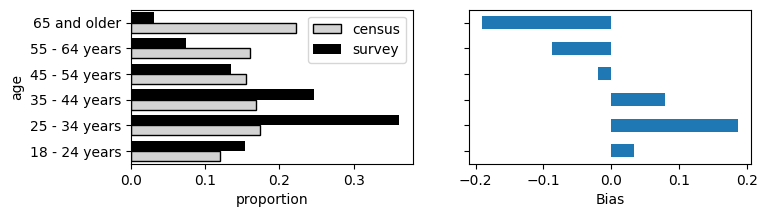

,survey N,census N,census proportion,survey proportion,bias
age,,,,,
18 - 24 years,768,31328131,0.120,0.153,0.033
25 - 34 years,1813,45501300,0.174,0.361,0.187
35 - 44 years,1240,43695365,0.168,0.247,0.079
45 - 54 years,677,40431645,0.155,0.135,-0.020
55 - 64 years,374,42085437,0.161,0.074,-0.087
65 and older,155,57794852,0.222,0.031,-0.191


In [17]:
print('Our sampling frame without stratification compared to census data:')
sampling_frame = get_sampling_frame(collapse_age=False)
age_nocollapse_df = sampling_frame['age'].value_counts().sort_index().rename('survey N').to_frame()
# Aggregate census data to age groups matching survey data
age_nocollapse_df['census N'] = [
    census_age_df[census_age_df['AGE'].isin(range(18,25))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(25,35))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(35,45))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(45,55))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(55,65))]['N'].sum(),
    census_age_df[census_age_df['AGE'] >= 65]['N'].sum(),
]
age_nocollapse_df = set_proportions_and_bias(age_nocollapse_df)
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 2), sharey=True)
plot_census_vs_survey_pops(age_nocollapse_df, ax=ax1)
plot_bias(age_nocollapse_df, ax=ax2)
plt.show()
age_nocollapse_df

When collapsing age groups to 3 groups

Our sampling frame without stratification compared to census data:


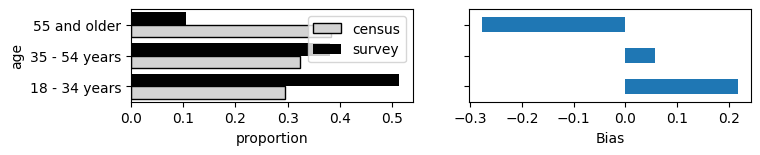

,survey N,census N,census proportion,survey proportion,bias
age,,,,,
18 - 34 years,2581,76829431,0.295,0.513,0.218
35 - 54 years,1917,84127010,0.323,0.381,0.058
55 and older,529,99880289,0.383,0.105,-0.278


In [18]:
print('Our sampling frame without stratification compared to census data:')
sampling_frame = get_sampling_frame(collapse_age=True)
age_df = sampling_frame['age'].value_counts().sort_index().rename('survey N').to_frame()
# Aggregate census data to age groups matching survey data
age_df['census N'] = [
    census_age_df[census_age_df['AGE'].isin(range(18,35))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(35,55))]['N'].sum(),
    census_age_df[census_age_df['AGE'] >= 55]['N'].sum(),
]
age_df = set_proportions_and_bias(age_df)
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 1.2), sharey=True)
plot_census_vs_survey_pops(age_df, ax=ax1)
plot_bias(age_df, ax=ax2)
plt.show()
age_df

In [19]:
def get_stratified_sample(stratify_by_df, sampling_frame, stratify_col='age', verbose=True):
    assert(round(stratify_by_df['census proportion'].sum()) == 1)
    assert(round(stratify_by_df['survey proportion'].sum()) == 1)
    # use the stratum most underrepresented in order to define strata sizes
    min_strata = (stratify_by_df['survey proportion']/stratify_by_df['census proportion']).idxmin()
    max_N = stratify_by_df['survey N'][min_strata]
    if verbose:
        print('using most underrepresented stratum to define strata sizes: %s; max N=%s' % (min_strata, max_N))
    stratify_N = round(
        (stratify_by_df['census N']/stratify_by_df['census N'][min_strata])*max_N
    ).astype(int)
    if verbose:
        print('sampling for N:')
        display(stratify_N)
    stratified_sample_df = pd.DataFrame(columns=sampling_frame.columns)
    for i, N in enumerate(stratify_N):
        strata = stratify_N.index[i]
        sampled_df = sampling_frame[
            sampling_frame[stratify_col] == strata
        ].sample(replace=False, n=N)
        stratified_sample_df = pd.concat([stratified_sample_df, sampled_df])
    return stratified_sample_df

In [20]:
sampling_frame_age_nocollapse = get_sampling_frame(collapse_age=False)
stratified_sample_df = get_stratified_sample(age_nocollapse_df, sampling_frame_age_nocollapse, stratify_col='age')
print('total sample size n=%s' % len(stratified_sample_df))
stratified_sample_df.head()

using most underrepresented stratum to define strata sizes: 65 and older; max N=155
sampling for N:


age
18 - 24 years     84
25 - 34 years    122
35 - 44 years    117
45 - 54 years    108
55 - 64 years    113
65 and older     155
Name: census N, dtype: int64

total sample size n=699


,age
R_2B38co9cwVRvVZA,18 - 24 years
R_2XnwTIr876b33Rs,18 - 24 years
R_1KkFs7rgWXlWf58,18 - 24 years
R_TmZ0K9e559ejvl7,18 - 24 years
R_w4X9FQneeSrzuE1,18 - 24 years


In [21]:
sampling_frame = get_sampling_frame(collapse_age=True)
stratified_sample_df = get_stratified_sample(age_df, sampling_frame, stratify_col='age')
print('total sample size n=%s' % len(stratified_sample_df))
stratified_sample_df.head()

using most underrepresented stratum to define strata sizes: 55 and older; max N=529
sampling for N:


age
18 - 34 years    407
35 - 54 years    446
55 and older     529
Name: census N, dtype: int64

total sample size n=1382


,age
R_cVbq9lQkBclFudr,18 - 34 years
R_1hR9j74rTpO8hbI,18 - 34 years
R_3I055DYANjeNW0Q,18 - 34 years
R_11apGEU5o3Mncee,18 - 34 years
R_3PbL63xQilAzpWi,18 - 34 years


age
18 - 34 years    0.295
35 - 54 years    0.323
55 and older     0.383
Name: proportion, dtype: float64

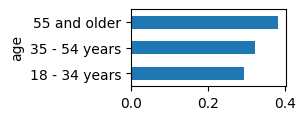

In [22]:
# Now show the age distribution for the stratified sample. 
# Proportions should match census data
stratified_age = stratified_sample_df['age'].value_counts(normalize=True).sort_index().round(3)
display(stratified_age)
fig, ax = plt.subplots(1,1, figsize=(2,1))
_ = stratified_age.plot.barh(ax)

### Age x sex

Using Age x sex vs just age slightly reduces sample size.

Our sampling frame without stratification compared to census data:


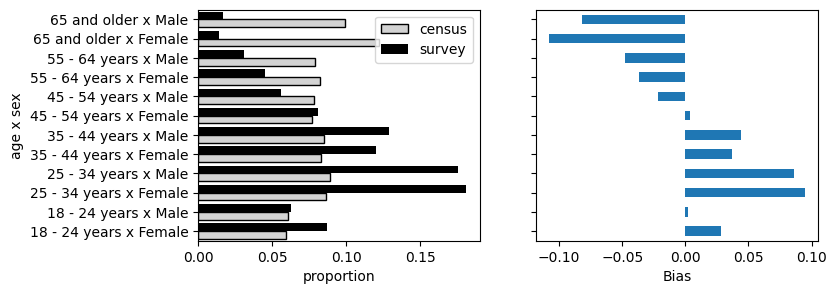

,survey N,census N,census proportion,survey proportion,bias
age x sex,,,,,
18 - 24 years x Female,424,15309475,0.059,0.087,0.028
18 - 24 years x Male,308,16018656,0.061,0.063,0.002
25 - 34 years x Female,888,22311738,0.086,0.181,0.095
25 - 34 years x Male,858,23189562,0.089,0.175,0.086
35 - 44 years x Female,590,21575176,0.083,0.120,0.037
35 - 44 years x Male,633,22120189,0.085,0.129,0.044
45 - 54 years x Female,397,20152015,0.077,0.081,0.004
45 - 54 years x Male,273,20279630,0.078,0.056,-0.022
55 - 64 years x Female,220,21413534,0.082,0.045,-0.037


In [23]:
print('Our sampling frame without stratification compared to census data:')
sampling_frame = get_sampling_frame(collapse_age=False, use_sex=True)
age_sex_nocollapse_df = sampling_frame['age x sex'].value_counts().sort_index().rename('survey N').to_frame()
# Aggregate census data to age groups matching survey data
age_sex_nocollapse_df['census N'] = [
    census_age_sex_df[(census_age_sex_df['SEX']==2) & census_age_sex_df['AGE'].isin(range(18,25))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & census_age_sex_df['AGE'].isin(range(18,25))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==2) & census_age_sex_df['AGE'].isin(range(25,35))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & census_age_sex_df['AGE'].isin(range(25,35))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==2) & census_age_sex_df['AGE'].isin(range(35,45))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & census_age_sex_df['AGE'].isin(range(35,45))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==2) & census_age_sex_df['AGE'].isin(range(45,55))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & census_age_sex_df['AGE'].isin(range(45,55))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==2) & census_age_sex_df['AGE'].isin(range(55,65))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & census_age_sex_df['AGE'].isin(range(55,65))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==2) & (census_age_sex_df['AGE'] >= 65)]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & (census_age_sex_df['AGE'] >= 65)]['N'].sum(),
]
age_sex_nocollapse_df = set_proportions_and_bias(age_sex_nocollapse_df)
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 3), sharey=True)
plot_census_vs_survey_pops(age_sex_nocollapse_df, ax=ax1)
plot_bias(age_sex_nocollapse_df, ax=ax2)
plt.show()
age_sex_nocollapse_df

When collapsing age to 3 groups

Our sampling frame without stratification compared to census data:


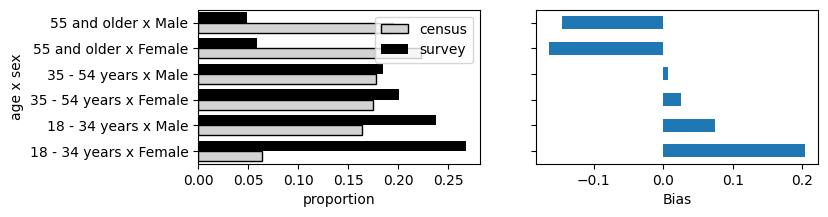

,survey N,census N,census proportion,survey proportion,bias
age x sex,,,,,
18 - 34 years x Female,1312,15309475,0.064,0.268,0.204
18 - 34 years x Male,1166,39208218,0.164,0.238,0.074
35 - 54 years x Female,987,41727191,0.175,0.201,0.026
35 - 54 years x Male,906,42399819,0.178,0.185,0.007
55 and older x Female,290,53279042,0.223,0.059,-0.164
55 and older x Male,239,46601247,0.195,0.049,-0.146


In [24]:
print('Our sampling frame without stratification compared to census data:')
sampling_frame = get_sampling_frame(collapse_age=True, use_sex=True)
age_sex_df = sampling_frame['age x sex'].value_counts().sort_index().rename('survey N').to_frame()
# Aggregate census data to age groups matching survey data
age_sex_df['census N'] = [
    census_age_sex_df[(census_age_sex_df['SEX']==2) & census_age_sex_df['AGE'].isin(range(18,25))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & census_age_sex_df['AGE'].isin(range(18,35))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==2) & census_age_sex_df['AGE'].isin(range(35,55))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & census_age_sex_df['AGE'].isin(range(35,55))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==2) & (census_age_sex_df['AGE'] >= 55)]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & (census_age_sex_df['AGE'] >= 55)]['N'].sum(),
]
age_sex_df = set_proportions_and_bias(age_sex_df)
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 2), sharey=True)
plot_census_vs_survey_pops(age_sex_df, ax=ax1)
plot_bias(age_sex_df, ax=ax2)
plt.show()
age_sex_df

In [25]:
sampling_frame_age_sex_nocollapse = get_sampling_frame(collapse_age=False, use_sex=True)
stratified_sample_df = get_stratified_sample(age_sex_nocollapse_df, sampling_frame_age_sex_nocollapse, stratify_col='age x sex')
print('total sample size n=%s' % len(stratified_sample_df))

using most underrepresented stratum to define strata sizes: 65 and older x Female; max N=70
sampling for N:


age x sex
18 - 24 years x Female    34
18 - 24 years x Male      35
25 - 34 years x Female    49
25 - 34 years x Male      51
35 - 44 years x Female    47
35 - 44 years x Male      49
45 - 54 years x Female    44
45 - 54 years x Male      45
55 - 64 years x Female    47
55 - 64 years x Male      45
65 and older x Female     70
65 and older x Male       57
Name: census N, dtype: int64

total sample size n=573


In [26]:
sampling_frame_age_sex = get_sampling_frame(collapse_age=True, use_sex=True)
stratified_sample_df = get_stratified_sample(age_sex_df, sampling_frame_age_sex, stratify_col='age x sex')
print('total sample size n=%s' % len(stratified_sample_df))

using most underrepresented stratum to define strata sizes: 55 and older x Male; max N=239
sampling for N:


age x sex
18 - 34 years x Female     79
18 - 34 years x Male      201
35 - 54 years x Female    214
35 - 54 years x Male      217
55 and older x Female     273
55 and older x Male       239
Name: census N, dtype: int64

total sample size n=1223


## Question: Does our sample of crowd worker participants move more often than the general population?

And what stratification strategies change this?


#### Result
Results indicate only by a few percentage points.

Experiments also show that estimates are most accurate when:
- stratify on age x sex
- incorporate household size

This test helps inform the rest of the analysis.


#### Data and methods

U.S. census data indicates ~12%-13% of people moved place of residence in 2021.

(Note the difference between general move vs move between regions)

Source (with plot): https://www2.census.gov/programs-surveys/demo/visualizations/geographic-mobility/acs-1yr/residence.pdf
> U.S. Census Bureau, 2006 to 2021 American Community Survey, 1-year estimates, Tables B07001 and DP02


Our survey asks: Q-life-changes:

"In 2021 did you, or someone you share your Amazon account with, experience any of the following life changes? Please mark all that apply."
- Lost a job
- Divorce
- Moved place of residence
- Became pregnant
- Had a child
- None of the above


Compute the number of participants who said they moved place of residence.

See how stratified random sampling impacts estimates. Resample N=1000 times to compute the estimate with similar strategies used in the rest of this analysis.


In [27]:
# insert 0/1 boolean indicator for whether they moved in 2021
survey_df['moved2021'] = survey_df['Q-life-changes'].apply(lambda q: 'Moved place of residence' in str(q)).astype(int)
N_subsamples = 1000
def compute_portion_movers_2021(sampled_df, by_hh_size=False):
    sdf = survey_df.loc[sampled_df.index]
    n = sdf['hh_size'].sum() if by_hh_size else len(sdf)
    n_moved_2021 = (sdf['moved2021']*sdf['hh_size']).sum() if by_hh_size else sdf['moved2021'].sum()
    return n_moved_2021/n

In [28]:
movers = [] # compute the mean over N_subsamples
for i in range(N_subsamples):
    sampled_df = get_sampling_frame()
    movers += [compute_portion_movers_2021(sampled_df)]
movers = round(pd.Series(movers).mean(), 4)
print('random sample N=%s' % len(sampled_df))
print('%0.4f = portion movers' % movers)

random sample N=5027
0.2170 = portion movers


In [29]:
# strafiy on collapsed age groups
movers = [] # compute the mean over N_subsamples
for i in range(N_subsamples):
    sampled_df = get_stratified_sample(age_df, get_sampling_frame(collapse_age=True), stratify_col='age', verbose=False)
    movers += [compute_portion_movers_2021(sampled_df)]
movers = round(pd.Series(movers).mean(), 4)
print('sample stratified on (collapsed) age groups N=%s' % len(sampled_df))
print('%0.4f = portion movers' % movers)

sample stratified on (collapsed) age groups N=1382
0.1748 = portion movers


In [30]:
# strafiy on collapsed age x sex groups
movers = [] # compute the mean over N_subsamples
sampling_frame = get_sampling_frame(collapse_age=True, use_sex=True)
for i in range(N_subsamples):
    sampled_df = get_stratified_sample(age_sex_df, sampling_frame, stratify_col='age x sex', verbose=False)
    movers += [compute_portion_movers_2021(sampled_df)]
movers = round(pd.Series(movers).mean(), 4)
print('sample stratified on (collapsed) age x sex groups N=%s' % len(sampled_df))
print('%0.4f = portion movers' % movers)

sample stratified on (collapsed) age x sex groups N=1223
0.1596 = portion movers


In [31]:
# use household size and stratify on collapsed age groups
movers = [] # compute the mean over N_subsamples
for i in range(N_subsamples):
    sampled_df = get_stratified_sample(age_df, get_sampling_frame(collapse_age=True), stratify_col='age', verbose=False)
    movers += [compute_portion_movers_2021(sampled_df, by_hh_size=True)]
movers = round(pd.Series(movers).mean(), 4)
print('using household size with sample stratified on (collapsed) age groups N=%s' % len(sampled_df))
print('%0.4f = portion movers' % movers)

using household size with sample stratified on (collapsed) age groups N=1382
0.1657 = portion movers


In [32]:
# use household size and stratify on collapsed age x sex groups
movers = [] # compute the mean over N_subsamples
sampling_frame = get_sampling_frame(collapse_age=True, use_sex=True)
for i in range(N_subsamples):
    sampled_df = get_stratified_sample(age_sex_df, sampling_frame, stratify_col='age x sex', verbose=False)
    movers += [compute_portion_movers_2021(sampled_df, by_hh_size=True)]
movers = round(pd.Series(movers).mean(), 4)
print('using household size with sample stratified on (collapsed) age x sex groups N=%s' % len(sampled_df))
print('%0.4f = portion movers' % movers)

using household size with sample stratified on (collapsed) age x sex groups N=1223
0.1510 = portion movers


In [33]:
# stratify on all age groups
movers = [] # compute the mean over N_subsamples
for i in range(N_subsamples):
    sampled_df = get_stratified_sample(age_nocollapse_df, get_sampling_frame(collapse_age=False), stratify_col='age', verbose=False)
    movers += [compute_portion_movers_2021(sampled_df)]
movers = round(pd.Series(movers).mean(), 4)
print('sample stratified on (all) age groups N=%s' % len(sampled_df))
print('%0.4f = portion movers' % movers)

sample stratified on (all) age groups N=699
0.1690 = portion movers


In [34]:
# stratify on all age groups
movers = [] # compute the mean over N_subsamples
sampling_frame = get_sampling_frame(collapse_age=False, use_sex=True)
for i in range(N_subsamples):
    sampled_df = get_stratified_sample(age_sex_nocollapse_df, sampling_frame, stratify_col='age x sex', verbose=False)
    movers += [compute_portion_movers_2021(sampled_df)]
movers = round(pd.Series(movers).mean(), 4)
print('sample stratified on (all) age x sex groups N=%s' % len(sampled_df))
print('%0.4f = portion movers' % movers)

sample stratified on (all) age x sex groups N=573
0.1661 = portion movers


In [35]:
# use houshold size and stratify on all age groups
movers = [] # compute the mean over N_subsamples
for i in range(N_subsamples):
    sampled_df = get_stratified_sample(age_nocollapse_df, get_sampling_frame(collapse_age=False), stratify_col='age', verbose=False)
    movers += [compute_portion_movers_2021(sampled_df, by_hh_size=True)]
movers = round(pd.Series(movers).mean(), 4)
print('using household size with sample stratified on (all) age groups N=%s' % len(sampled_df))
print('%0.4f = portion movers' % movers)

using household size with sample stratified on (all) age groups N=699
0.1590 = portion movers


In [36]:
# use houshold size and stratify on all age x sex groups
movers = [] # compute the mean over N_subsamples
sampling_frame = get_sampling_frame(collapse_age=False, use_sex=True)
for i in range(N_subsamples):
    sampled_df = get_stratified_sample(age_sex_nocollapse_df, sampling_frame, stratify_col='age x sex', verbose=False)
    movers += [compute_portion_movers_2021(sampled_df, by_hh_size=True)]
movers = round(pd.Series(movers).mean(), 4)
print('using household size with sample stratified on (all) age x sex groups N=%s' % len(sampled_df))
print('%0.4f = portion movers' % movers)

using household size with sample stratified on (all) age x sex groups N=573
0.1576 = portion movers


### Infer state of residence

In [37]:
# Paramters that yieled best results after testing are set as defaults

def infer_state_residence(df, drop_ties=True, months_threshold=2, max_monthly_states=3):
    """Returns np.nan or state of residence inferred from respondent's purchases data.
    Assumes input df is a for one response ID, for one year of data.
    Inference method:
    - Drops any rows with na
    - For each month in year: 
    - map month to state: get state with majority of shipments
    - Use state that appears in majority of months
    - In some months there is a tie. Then use all. 
    - Warning: If do not drop ties in final choice, will choose first (alphabetical) mode.
    """
    monthly_states = df.dropna().groupby(['yyyy-mm'])['state'].agg(pd.Series.mode)
    if len(monthly_states) < months_threshold: return np.nan
    states = np.array([])
    for s in monthly_states.values: states = np.append(states, np.array(s))
    states = pd.Series(states)
    if states.nunique() > max_monthly_states: return np.nan
    mode = states.mode()
    if len(mode) > 1 and drop_ties:
        return np.nan
    return mode[0]

#### Test inference method

Test the method using 2021 data

- Limit amazon data to 2021 and test for each response ID in the amazon data
- Compare to survey data

Make a dataframe for evaluation: `eval_df`

```
response ID, inferred, survey
```
where:
- `inferred` is inferred from the Amazon data
- `survey` is from the survey response

In [53]:
amzn_2021_df = amzn_df[amzn_df['year']==2021]
rids = amzn_2021_df['Survey ResponseID'].unique()

In [54]:
inferred = []
for i, rid in enumerate(rids):
    if i % 2000 == 0:
        print('%s: %s/%s' % (pd.Timestamp.now(), i, len(rids)))
    infererence = infer_state_residence(amzn_2021_df[amzn_2021_df['Survey ResponseID']==rid])
    inferred += [infererence]

2023-09-06 11:12:49.765627: 0/4862
2023-09-06 11:13:14.299496: 2000/4862
2023-09-06 11:13:39.027864: 4000/4862


In [55]:
pd.Series(inferred).nunique()

51

In [60]:
eval_df = pd.DataFrame({'ResponseId': rids, 'inferred': inferred}).set_index('ResponseId')
eval_df['survey'] = eval_df.index.map(responseid_to_state)
print('dropping %s/%s na inferences' % (eval_df['inferred'].isna().sum(), len(eval_df)))
eval_df = eval_df.dropna()
print('N=%s' % len(eval_df))

# attach survey data to help evaluate
eval_df['match'] = eval_df.apply(lambda r: r['inferred']==r['survey'], axis=1)
print('match rate = %0.3f' % (eval_df['match'].sum()/len(eval_df)))
# connect demographics to the eval df
eval_df = eval_df.merge(survey_df, how='left', left_index=True, right_index=True)
bad_inference = eval_df[eval_df['match']==False]
print('%s bad matches' % len(bad_inference))
print('without bad matches: N=%s' % (len(eval_df[eval_df['match']==True])))
eval_df.head(3)

dropping 373/4862 na inferences
N=4487
match rate = 0.964
163 bad matches
without bad matches: N=4324


,inferred,survey,match,age,hispanic,race,education,gender,state,accnt_users,hh_size,Q-life-changes,num_users_gt_hh_size,moved2021
ResponseId,,,,,,,,,,,,,,
R_3I9Pu8iauEcOx9A,RI,RI,True,35 - 44 years,No,White or Caucasian,Bachelor's degree,Male,Rhode Island,1,2,NaN,False,0
R_7UtikIBqeQHvnyN,AL,AL,True,25 - 34 years,No,Black or African American,High school diploma or GED,Female,Alabama,1,2,NaN,False,0
R_2B2MGUXpwb5RnOZ,MO,MO,True,25 - 34 years,No,White or Caucasian,High school diploma or GED,Female,Missouri,1,1,NaN,False,0
R_1Nnv2IYQFpUwHrr,NY,NY,True,25 - 34 years,No,Asian,"Graduate or professional degree (MA, MS, MBA, ...",Female,New York,2,3,NaN,False,0
R_3QXUWuTn4OdbNmh,TX,TX,True,18 - 24 years,Yes,White or Caucasian,High school diploma or GED,Male,Texas,1,2,Lost a job,False,0


In [65]:
# Drop rows s.t. users > hh size
print('dropping %s rows where num users more than hh size' % ((eval_df['num_users_gt_hh_size']>0).sum()))
print('match rate = %0.3f' % (
    eval_df[~(eval_df['num_users_gt_hh_size']>0)]['match'].sum()/len(eval_df[~(eval_df['num_users_gt_hh_size']>0)])))
print('remaning N=%s' % len(eval_df[~(eval_df['num_users_gt_hh_size']>0)]))

dropping 193 rows where num users more than hh size
match rate = 0.966
remaning N=4294


Since this choice is made for implementation, get the list of all ResponseIds that should be dropped for larger estimation process. First add this as a boolean to the overall survey data.

In [87]:
# collect the bad matches
bad_inference = eval_df[eval_df['match']==False]
print('%s bad matches' % len(bad_inference))
# collect the ResponseIds for the bad matches
bad_inference_rids = bad_inference.index

163 bad matches


## Estimate yearly residence

Make a table: state_residence

```
response ID, 2018, 2019, 2020, 2021, 2022, demographics ...
```

Where:
- Each value for 2018, 2019, ..., 2022 is the inferred state of residence

- Drop response ID rows with na data for any year

- Demographics attached for stratified sampling
    - we know data is biased towards more females, fewer older folks

Use state_residence table to make region_residence table

Use tables to estimate yearly population changes (due to domestic migration)

In [90]:
rids = amzn_df['Survey ResponseID'].unique()
print('%s response IDs across all Amazon data' % len(rids))
inferred_years = dict()
for year in [2018, 2019, 2020, 2021, 2022]:
    amzn_yr_df = amzn_df[amzn_df['year']==year]
    inferred_yr = []
    for i, rid in enumerate(rids):
        if i % 2000 == 0:
            print('%s: handling year %s: %s/%s' % (pd.Timestamp.now(), year, i, len(rids)))
        infererence = infer_state_residence(amzn_yr_df[amzn_yr_df['Survey ResponseID']==rid])
        inferred_yr += [infererence]
    inferred_years[year] = inferred_yr

5027 response IDs across all Amazon data
2023-09-06 11:38:30.105380: handling year 2018: 0/5027
2023-09-06 11:38:42.348769: handling year 2018: 2000/5027
2023-09-06 11:38:54.659144: handling year 2018: 4000/5027
2023-09-06 11:39:01.010004: handling year 2019: 0/5027
2023-09-06 11:39:15.510172: handling year 2019: 2000/5027
2023-09-06 11:39:29.935606: handling year 2019: 4000/5027
2023-09-06 11:39:37.318143: handling year 2020: 0/5027
2023-09-06 11:39:59.233017: handling year 2020: 2000/5027
2023-09-06 11:40:20.919956: handling year 2020: 4000/5027
2023-09-06 11:40:32.041406: handling year 2021: 0/5027
2023-09-06 11:40:56.788442: handling year 2021: 2000/5027
2023-09-06 11:41:21.412753: handling year 2021: 4000/5027
2023-09-06 11:41:34.165371: handling year 2022: 0/5027
2023-09-06 11:41:57.753056: handling year 2022: 2000/5027
2023-09-06 11:42:20.940172: handling year 2022: 4000/5027


In [172]:
state_residence = pd.DataFrame({
    'ResponseId': rids, 
    '2018': inferred_years[2018],
    '2019': inferred_years[2019],
    '2020': inferred_years[2020],
    '2021': inferred_years[2021],
    '2022': inferred_years[2022],
}).set_index('ResponseId')
state_residence.head()

,2018,2019,2020,2021,2022
ResponseId,,,,,
R_3I9Pu8iauEcOx9A,RI,RI,RI,RI,RI
R_7UtikIBqeQHvnyN,NaN,SC,AL,AL,AL
R_2PpVNZupgA2k9mX,NaN,NaN,AL,NaN,NaN
R_2B2MGUXpwb5RnOZ,NaN,MO,NaN,MO,MO
R_1Nnv2IYQFpUwHrr,NY,NY,NY,NY,NY


In [173]:
# Connect the demographic info
state_residence = state_residence.merge(
    survey_df[['age','gender','hispanic','race','education', 'hh_size','num_users_gt_hh_size']],
    how='left', left_index=True, right_index=True
)
state_residence.head(3)

,2018,2019,2020,2021,2022,age,gender,hispanic,race,education,hh_size,num_users_gt_hh_size
ResponseId,,,,,,,,,,,,
R_3I9Pu8iauEcOx9A,RI,RI,RI,RI,RI,35 - 44 years,Male,No,White or Caucasian,Bachelor's degree,2,False
R_7UtikIBqeQHvnyN,NaN,SC,AL,AL,AL,25 - 34 years,Female,No,Black or African American,High school diploma or GED,2,False
R_2PpVNZupgA2k9mX,NaN,NaN,AL,NaN,NaN,18 - 24 years,Female,No,White or Caucasian,High school diploma or GED,3,False


Make region residence table.

Use regions as defined by the Census Bureau in order to match our data to Census data.
Map of regions: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf

In [174]:
state_regions_df = pd.read_csv('../data/census/us-census-bureau-regions-and-divisions.csv').set_index('State Code')
print('Regions:', state_regions_df['Region'].unique())
state_regions_df.head()

Regions: ['West' 'South' 'Northeast' 'Midwest']


,State,Region,Division
State Code,,,
AK,Alaska,West,Pacific
AL,Alabama,South,East South Central
AR,Arkansas,South,West South Central
AZ,Arizona,West,Mountain
CA,California,West,Pacific


In [175]:
states_to_regions = state_regions_df['Region']

In [176]:
# copy the state residence df and replace states with regions
region_residence = state_residence.copy()
for year in [2018, 2019, 2020, 2021, 2022]:
    year = str(year)
    region_residence[year] = region_residence[year].map(states_to_regions)
region_residence.head(3)

,2018,2019,2020,2021,2022,age,gender,hispanic,race,education,hh_size,num_users_gt_hh_size
ResponseId,,,,,,,,,,,,
R_3I9Pu8iauEcOx9A,Northeast,Northeast,Northeast,Northeast,Northeast,35 - 44 years,Male,No,White or Caucasian,Bachelor's degree,2,False
R_7UtikIBqeQHvnyN,NaN,South,South,South,South,25 - 34 years,Female,No,Black or African American,High school diploma or GED,2,False
R_2PpVNZupgA2k9mX,NaN,NaN,South,NaN,NaN,18 - 24 years,Female,No,White or Caucasian,High school diploma or GED,3,False


In [177]:
def get_yearly_residence_sampling_frame(df=state_residence, drop_bad_inference_rids=True, **kwargs):
    df2 = df.drop(bad_inference_rids, errors='ignore') if drop_bad_inference_rids else df
    return get_sampling_frame(df, **kwargs)

## Movement between regions


Compare to Census data from Table S0702

Uses data from ACS Q that asks: "Where did you live 1 year ago?"



- In 2019: 0.01215 of the US population moved between regions (i.e. moved to current region from another region in 2018)
- 2020 and 2021 similarly ~0.012 total move rate


To get this started:
- for each yr (starting with 2019 vs 2018) compute the portion of participants who moved between regions
- compare to census data
- experiment with how stratified random sampling improves comparisons
- repeat

Census data for comparison

In [178]:
census_pop_flows = (
    pd.read_csv(census_data_dir + 'S0702-aggregated.csv')
    .set_index('Geography')[['2019 rate', '2020 rate', '2021 rate']]
    .loc[[
        'US total',
        'Total to Northeast',
        'Midwest to Northeast',
        'South to Northeast',
        'West to Northeast',
        'Total to Midwest',
        'Northeast to Midwest',
        'South to Midwest',
        'West to Midwest',
        'Total to South',
        'Northeast to South',
        'Midwest to South',
        'West to South',
        'Total to West',
        'Northeast to West',
        'Midwest to West',
        'South to West',
    ]].astype(float).round(5))
census_pop_flows

,2019 rate,2020 rate,2021 rate
Geography,,,
US total,0.01215,0.01203,0.01205
Total to Northeast,0.00959,0.00962,0.00976
Midwest to Northeast,0.00169,0.00169,0.00170
South to Northeast,0.00555,0.00551,0.00554
West to Northeast,0.00235,0.00242,0.00253
Total to Midwest,0.01156,0.01136,0.01138
Northeast to Midwest,0.00178,0.00179,0.00178
South to Midwest,0.00617,0.00604,0.00598
West to Midwest,0.00360,0.00353,0.00361


In [179]:
# validate this data: values should not change much between years
print('correlation matrix between years')
census_pop_flows.corr()

correlation matrix between years


,2019 rate,2020 rate,2021 rate
2019 rate,1.000000,0.999799,0.998726
2020 rate,0.999799,1.000000,0.999408
2021 rate,0.998726,0.999408,1.000000


In [180]:
reg_totals_idx = [idx for idx in census_pop_flows.index if idx.startswith('Total')]
census_pop_flows_region_totals = census_pop_flows.loc[reg_totals_idx].sort_index()
census_pop_flows_region_totals

,2019 rate,2020 rate,2021 rate
Geography,,,
Total to Midwest,0.01156,0.01136,0.01138
Total to Northeast,0.00959,0.00962,0.00976
Total to South,0.01319,0.01310,0.01331
Total to West,0.01285,0.01265,0.01232


In [181]:
# simple way to identify movers
# f_moved = lambda r: r[curr_yr] != r[prev_yr]

def get_movers(df, yr, to_region=None, from_region=None, round_to=5, by_hh_size=False):
    curr_yr = str(yr)
    prev_yr = str(int(yr)-1)
    # drop rows that do not have values for both previous and current year
    df = df[[prev_yr, curr_yr, 'hh_size']].dropna()
    # Region of to region is the current population and denominator
    if to_region is not None:
        df = df[df[curr_yr]==to_region]
    curr_pop = df['hh_size'].sum() if by_hh_size else len(df)
    f_moved = lambda r: int(r[curr_yr] != r[prev_yr]) # 0=False;1=True
    if from_region is not None:
        f_moved = lambda r: int(r[prev_yr] == from_region)
    moved_n = (df.apply(f_moved, axis=1)*df['hh_size']).sum() if by_hh_size else df.apply(f_moved, axis=1).sum()
    label = '%s%s'%((from_region or 'Total'), (' to %s'%to_region if to_region else ''))
    return [label, curr_pop, moved_n, round(moved_n/curr_pop, round_to)]

First compare our data to survey data using just 2019

In [182]:
curr_yr = '2019'
# Make a table with the totals to the regions
df = region_residence
print('Total estimated rate of U.S. movers = %0.4f' % get_movers(df, curr_yr)[-1])
survey_sample_flows_region_totals = pd.DataFrame(
    [get_movers(df, curr_yr, to_region=reg) for reg in regions],
    columns=['Geography', '%s sample'%curr_yr, '%s movers'%curr_yr, '%s rate'%curr_yr]
).set_index('Geography')
survey_sample_flows_region_totals

Total estimated rate of U.S. movers = 0.0242


,2019 sample,2019 movers,2019 rate
Geography,,,
Total to Midwest,809,18,0.02225
Total to Northeast,655,15,0.02290
Total to South,1222,22,0.01800
Total to West,750,28,0.03733


Without any filtering or stratification, we have a lot of 2019 movers!

In [194]:
# Using household size
curr_yr = '2019'
df = region_residence
print('using household size')
print('N=%s' % len(df))
N_movers = get_movers(df, curr_yr, by_hh_size=True)[-1]
print('Total estimated rate of U.S. movers = %0.4f' % N_movers)
# drop bad inference ids, stratify on age x sex
print('\nWhen drop na, drop bad inference ids, stratify on age x sex')
sampling_frame = get_yearly_residence_sampling_frame(region_residence, drop_bad_inference_rids=True, dropna=True, use_sex=True)
stratified_sample = get_stratified_sample(age_sex_df, sampling_frame, stratify_col='age x sex', verbose=False)
df = region_residence.loc[stratified_sample_df.index]
print('N=%s' % len(df))
N_movers = get_movers(df, curr_yr)[-1]
print('Total estimated rate of U.S. movers = %0.4f' % N_movers)
# drop na, drop bad inference ids, stratify on age x sex
print('\nWhen using household size, drop na, drop bad inference ids, stratify on age x sex')
print('N=%s' % len(df))
N_movers = get_movers(df, curr_yr, by_hh_size=True)[-1]
print('Total estimated rate of U.S. movers = %0.4f' % N_movers)

using household size
N=5027
Total estimated rate of U.S. movers = 0.0226

When drop na, drop bad inference ids, stratify on age x sex
N=1382
Total estimated rate of U.S. movers = 0.0182

When using household size, drop na, drop bad inference ids, stratify on age x sex
N=1382
Total estimated rate of U.S. movers = 0.0154


When stratifying on (collapsed) age x sex and using household size: Wow rate of movers is 0.003 points away!

#### Pipeline with resampling

To create more robust estimates with our small sample, use a resampling pipeline with N stratified subsamples. 
- For each subsample in N:
    - draw stratified random sample (stratified on collapsed age groups)
    - compute table of survey sample flows from and to regions
- compute means over the N sumbsamples for rate of movers between regions for each year
- evaluate: compute correlation by comparing mean rates to census rates

In [219]:
# get census comparison df
census_pop_flows_from_to_region = census_pop_flows.loc[survey_sample_flows_from_to_region.index]
census_pop_flows_from_to_region

,2019 rate,2020 rate,2021 rate
Geography,,,
Northeast to Midwest,0.00178,0.00179,0.00178
South to Midwest,0.00617,0.00604,0.00598
West to Midwest,0.00360,0.00353,0.00361
Midwest to Northeast,0.00169,0.00169,0.00170
South to Northeast,0.00555,0.00551,0.00554
West to Northeast,0.00235,0.00242,0.00253
Midwest to South,0.00443,0.00428,0.00426
Northeast to South,0.00443,0.00435,0.00433
West to South,0.00433,0.00448,0.00472


From year to year the migration patterns do not change much.

In [254]:
census_pop_flows_from_to_region.corr()

,2019 rate,2020 rate,2021 rate
2019 rate,1.000000,0.998883,0.994294
2020 rate,0.998883,1.000000,0.997785
2021 rate,0.994294,0.997785,1.000000


In [251]:
N_subsamples = 1000
survey_sample_flows_dfs = []
for i in range(N_subsamples):
    sampling_frame = get_yearly_residence_sampling_frame(region_residence, drop_bad_inference_rids=True, dropna=True, use_sex=True)
    stratified_sample = get_stratified_sample(age_sex_df, sampling_frame, stratify_col='age x sex', verbose=False)
    df = region_residence.loc[stratified_sample.index]
    if i == 0:
        print('N=%s' % len(df))
    if i % 200 == 0:
        print('%s/%s' % (i+1, N_subsamples))
    survey_sample_flows_df = pd.DataFrame(
        [], index=census_pop_flows_from_to_region.index
    )
    # compute data for each year (note census data not available for 2022)
    for yr in [2019, 2020, 2021, 2022]:
        # get a df for the sample pop and movers for the given year and merge into larger table
        yr_df = pd.DataFrame(
            [get_movers(df, yr, to_region=to_reg, from_region=from_reg, by_hh_size=True) for to_reg in regions for from_reg in regions if from_reg != to_reg],
            columns=['Geography', '%s sample'%yr, '%s movers'%yr, '%s rate'%yr]
        ).set_index('Geography')
        survey_sample_flows_df = survey_sample_flows_df.merge(
            yr_df, left_index=True, right_index=True
        )
    survey_sample_flows_dfs += [survey_sample_flows_df]

N=1223
1/1000
201/1000
401/1000
601/1000
801/1000


In [252]:
# aggregregate the dfs by mean
adf = pd.concat(survey_sample_flows_dfs)
survey_mean_rates = adf.groupby(adf.index).mean()[['%s rate'%yr for yr in [2019, 2020, 2021]]]
# make sure the index is sorted in same way as census data
survey_mean_rates = survey_mean_rates.loc[census_pop_flows_from_to_region.index]
survey_mean_rates

,2019 rate,2020 rate,2021 rate
Geography,,,
Northeast to Midwest,0.001224,0.001704,0.002146
South to Midwest,0.009570,0.002990,0.003178
West to Midwest,0.004250,0.008290,0.011755
Midwest to Northeast,0.001449,0.000923,0.000846
South to Northeast,0.004756,0.011541,0.016192
West to Northeast,0.003956,0.002905,0.003576
Midwest to South,0.011105,0.007427,0.011464
Northeast to South,0.009775,0.005455,0.005633
West to South,0.003347,0.006817,0.013887


In [253]:
for yr in [2019, 2020, 2021]:
    print(yr)
    census_col = census_pop_flows_from_to_region['%s rate'%yr].astype(float)
    survey_col = survey_mean_rates['%s rate'%yr].astype(float)
    print('Spearman r: %0.3f, p=%0.3f' % stats.spearmanr(census_col, survey_col))
    print('Pearson r: %0.3f, p=%0.3f' % stats.pearsonr(census_col, survey_col))

2019
Spearman r: 0.830, p=0.001
Pearson r: 0.774, p=0.003
2020
Spearman r: 0.727, p=0.007
Pearson r: 0.694, p=0.012
2021
Spearman r: 0.573, p=0.051
Pearson r: 0.563, p=0.057


---

## Earlier tests

Check / verify what might be interesting about these movers to help inform the stratification and filtering strategies.

Logistic regression (using 2019 movers data) indicates age and age x region is important.

Gender alone is less important.

In [214]:
# check what might be interesting about these movers
region_residence['male'] = region_residence['gender'].apply(lambda g: 1 if g=='Male' else 0)
df_2019_movers = region_residence.copy().dropna()
# dependent variable is whether they moved:
f_moved = lambda r: r['2019'] != r['2018']
df_2019_movers['moved_2019'] = df_2019_movers.apply(f_moved, axis=1).astype(int)
df_2019_movers['y2019'] = df_2019_movers['2019']

In [215]:
# collapsed age groups
df_2019_movers['age'] = df_2019_movers['age'].map(collapse_age_map)

formula = 'moved_2019 ~ age + age:y2019 + male'
smf.logit(formula=formula, data=df_2019_movers).fit().summary()

         Current function value: 0.104369
         Iterations: 35


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             moved_2019   No. Observations:                 3141
Model:                          Logit   Df Residuals:                     3128
Method:                           MLE   Df Model:                           12
Date:                Wed, 06 Sep 2023   Pseudo R-squ.:                 0.04428
Time:                        17:41:12   Log-Likelihood:                -327.82
converged:                      False   LL-Null:                       -343.01
Covariance Type:            nonrobust   LLR p-value:                  0.002447
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -3.3122      0.314    -10.561      0.000      -3.927      -2.698
age[T.35 - 54 years]                     -1.1706      0.583     -2.008      0.045      -2.313      -0.028
age[T.55 and older]                      -1.2671      1.048     -1.209      0.226      -3.321       0.786
age[18 - 34 years]:y2019[T.Northeast]    -0.0401      0.436     -0.092      0.927      -0.895       0.815
age[35 - 54 years]:y2019[T.Northeast]    -1.1448      1.121     -1.021      0.307      -3.342       1.053
age[55 and older]:y2019[T.Northeast]    -23.6974   1.62e+05     -0.000      1.000   -3.18e+05    3.18e+05
age[18 - 34 years]:y2019[T.South]        -0.7624      0.447     -1.706      0.088      -1.638       0.114
age[35 - 54 years]:y2019[T.South]         0.0362      0.650      0.056      0.956      -1.237       1.309
age[55 and older]:y2019[T.South]          1.2971      1.104      1.175      0.240      -0.867       3.461
age[18 - 34 years]:y2019[T.West]         -0.2195      0.449     -0.489      0.625      -1.099       0.660
age[35 - 54 years]:y2019[T.West]          1.4617      0.573      2.551      0.011       0.339       2.585
age[55 and older]:y2019[T.West]          -0.0741      1.422     -0.052      0.958      -2.861       2.713
male                                      0.1547      0.241      0.643      0.520      -0.317       0.626
=========================================================================================================
"""

## Earlier / Other method / Other cenesus data: Estimate populations and changes

Use survey data in comparison to census data.


Census data estimates are downloaded from https://www2.census.gov/programs-surveys/popest/tables/

Overall population estimates are from:

> Annual Estimates of the Resident Population for the United States, Regions, States, the District of Columbia, and Puerto Rico: April 1, 2010 to July 1, 2019; April 1, 2020; and July 1, 2020 (NST-EST2020)	

Source: U.S. Census Bureau, Population Division														

Population change estimates are from: 

> Estimates of the Components of Resident Population Change for the United States, Regions, States, and Puerto Rico: July 1, 2018 to July 1, 2019 
(NST-EST2019-05)"							

Source: U.S. Census Bureau, Population Division		

(Above citaions for 1 yr of data. Similar citations for other years).

I compiled the data after downloading each of the tables from the census website into one spreadsheet: [link](https://docs.google.com/spreadsheets/d/1gNOTdUQ90Zo_wLDAeakQ25M10nL5MnAudBH0-hJBJs4/edit#gid=800468473)

These data are used as a point of comparison for the survey data estimates.

Note these changes are only available as estimates for:
- 2018 to 2019
- 2020 to 2021
- 2021 to 2022

In [102]:
# Drop U.S. total (X) and Puerto Rico.
census_pop_changes_by_region_state_df = pd.read_csv(
    census_data_dir + 'pop-changes-by-region-state-NST-EST.csv',
    usecols=['Geographic Area', 
             'domestic migration rate: 2018 - 2019',
             'domestic migration rate: 2020 - 2021',
             'domestic migration rate: 2021 - 2022'],
).set_index('Geographic Area').drop(['United States', 'Puerto Rico'])
census_pop_changes_by_region_state_df.head()

,domestic migration rate: 2018 - 2019,domestic migration rate: 2020 - 2021,domestic migration rate: 2021 - 2022
Geographic Area,,,
Northeast,-0.00525,-0.006782,-0.00805
Midwest,-0.00237,-0.001785,-0.00253
South,0.00327,0.005201,0.00682
West,0.00062,-0.001843,-0.00297
Alabama,0.00192,0.004400,0.00567


Separate region vs state.

And to be more concise, just make it year X - Y.

In [103]:
regions = ['Midwest', 'Northeast', 'South', 'West']
census_pop_changes_by_region = census_pop_changes_by_region_state_df.loc[regions].rename(columns={
    'domestic migration rate: 2018 - 2019': '2018-2019',  
    'domestic migration rate: 2020 - 2021': '2020-2021',  
    'domestic migration rate: 2021 - 2022': '2021-2022',  
})
census_pop_changes_by_region

,2018-2019,2020-2021,2021-2022
Geographic Area,,,
Midwest,-0.00237,-0.001785,-0.00253
Northeast,-0.00525,-0.006782,-0.00805
South,0.00327,0.005201,0.00682
West,0.00062,-0.001843,-0.00297


In [104]:
census_pop_changes_by_state = census_pop_changes_by_region_state_df.drop(regions).rename(columns={
    'domestic migration rate: 2018 - 2019': '2018-2019',  
    'domestic migration rate: 2020 - 2021': '2020-2021',  
    'domestic migration rate: 2021 - 2022': '2021-2022', 
})
# important to match the index to the survey data
census_pop_changes_by_state.index = census_pop_changes_by_state.index.map(state_codes)
census_pop_changes_by_state = census_pop_changes_by_state.sort_index()
census_pop_changes_by_state.head(3)

,2018-2019,2020-2021,2021-2022
Geographic Area,,,
AK,-0.01287,-0.005293,-0.00834
AL,0.00192,0.004400,0.00567
AR,0.00083,0.005314,0.00601


### From survey data: estimate populations and changes

For each year, aggregate to estimate the state/region populations for the sample to make a table:

```
state, 2018, 2019, 2020, 2021, 2022
```
and
```
region, 2018, 2019, 2020, 2021, 2022
```
and estimate change rates across years as percent of population in previous year

```
state, 2018, 2019, 2020, 2021, 2022, change rate: 2018-2019, change rate: 2020-2021, change rate: 2021-2022
```

Where:
- the values for 2018, ..., 2022 are the aggregate counts for the region
- change rate: year X-Y = (Y-X)/X

Then can estimate changes across years

A few ways to do this, differing by how how data are filtered before aggregating by state/region:
1. No data filtered -- nixed after testing: It's important to filter out Nan values b/c otherwise there is simply an increase over the years as more people started using Amazon
2. Limit data to rows without NaN values
3. 2 & filter out rows for ResponseIds where survey response did not match inferred 2021 residence
4. filter out rows s.t. num users > hh size
5. 3 & 4
6. 3 & multiply by household size
7. Stratify based on age
8. Stratify based on age x sex

Consider multiplying by household size, assuming people moved with their household.

In [105]:
def get_change_rate(df):
    """
    Compute the same way as computed in the census data:
    change rate: year X-Y = (Y-X)/X
    """
    for (x, y) in [(2018, 2019), (2019, 2020), (2020, 2021), (2021, 2022)]:
        (x, y) = (str(x), str(y))
        df['%s-%s'%(x,y)] = (df[y] - df[x])/df[x]
    return df
    
def get_counts_and_change_rate(df, by_hh_size=False, geos=None):
    """
    When by hh size: 
    Implementation iteratively limits by each year x geo and then sums across hh size values.
    geos is name of geographies (areas or state)
    yr_geos_vals maps each year to a list of values for each geo.
    """
    df = df.dropna() # important to filter out na
    if geos is None:
        geos = sorted(df['2018'].unique())
    years = ['2018', '2019','2020','2021','2022']
    yr_geos_vals = {yr: [len(df[df[yr]==geo]) for geo in geos] for yr in years}
    if by_hh_size:
        yr_geos_vals = {yr: [df[df[yr]==geo]['hh_size'].sum() for geo in geos] for yr in years}
    yr_counts_df = pd.DataFrame(yr_geos_vals, index=geos).rename_axis('Geographic Area')
    return get_change_rate(yr_counts_df)

Set up comparing census data to survey data

In [106]:
from scipy import stats

def compare_census_v_survey_changes(census_changes_df, survey_changes_df):
    for yr_change_col in census_pop_changes_by_region.columns:
        print(yr_change_col)
        census_col = census_changes_df[yr_change_col].astype(float)
        survey_col = survey_changes_df[yr_change_col].astype(float)
        print('Spearman r: %0.3f, p=%0.3f' % stats.spearmanr(census_col, survey_col))
        print('Pearson r: %0.3f, p=%0.3f' % stats.pearsonr(census_col, survey_col))

def evaluate_region_changes(reg_changes_df):
    return compare_census_v_survey_changes(census_pop_changes_by_region, reg_changes_df)

def evaluate_state_changes(state_changes_df):
    return compare_census_v_survey_changes(census_pop_changes_by_state, state_changes_df)

In [107]:
sdf = get_counts_and_change_rate(state_residence.drop(bad_inference_rids))
print(len(sdf))
sdf.head()

51


,2018,2019,2020,2021,2022,2018-2019,2019-2020,2020-2021,2021-2022
Geographic Area,,,,,,,,,
AK,4,4,5,6,6,0.000000,0.250000,0.200000,0.000000
AL,41,42,40,40,40,0.024390,-0.047619,0.000000,0.000000
AR,29,29,28,30,29,0.000000,-0.034483,0.071429,-0.033333
AZ,51,54,54,53,54,0.058824,0.000000,-0.018519,0.018868
CA,296,305,296,299,297,0.030405,-0.029508,0.010135,-0.006689


In [108]:
evaluate_state_changes(sdf)

2018-2019
Spearman r: 0.029, p=0.838
Pearson r: -0.073, p=0.609
2020-2021
Spearman r: 0.005, p=0.974
Pearson r: -0.147, p=0.304
2021-2022
Spearman r: -0.015, p=0.918
Pearson r: 0.076, p=0.594


In [109]:
# Limiting to rows with no NaN values
print('%s total rows ' % len(region_residence))
print('%s rows after dropping rows with Nan values' % len(region_residence.dropna()))
region_pop_2 = get_counts_and_change_rate(region_residence)
region_pop_2

5027 total rows 
3141 rows after dropping rows with Nan values


,2018,2019,2020,2021,2022,2018-2019,2019-2020,2020-2021,2021-2022
Geographic Area,,,,,,,,,
Midwest,745,745,744,736,732,0.000000,-0.001342,-0.010753,-0.005435
Northeast,608,605,600,603,601,-0.004934,-0.008264,0.005000,-0.003317
South,1129,1119,1130,1139,1142,-0.008857,0.009830,0.007965,0.002634
West,659,672,667,663,666,0.019727,-0.007440,-0.005997,0.004525


In [110]:
evaluate_region_changes(region_pop_2)

2018-2019
Spearman r: -0.200, p=0.800
Pearson r: 0.105, p=0.895
2020-2021
Spearman r: 0.200, p=0.800
Pearson r: 0.250, p=0.750
2021-2022
Spearman r: 0.000, p=1.000
Pearson r: 0.480, p=0.520


Filtering out rows where did not properly infer 2021 residence: This is now slightly more correct.

In [111]:
# Filter out rows where did not properly infer 2021 residence
print('%s bad residence inferences from 2021 data vs survey response' % len(bad_inference_rids))
region_residence_3 = region_residence.drop(bad_inference_rids).dropna()
print('%s rows after dropping rows with wrong 2021 residence inferences and Nan values' % 
      len(region_residence_3))
region_pop_3 = get_counts_and_change_rate(region_residence_3)
evaluate_region_changes(region_pop_3)
region_pop_3

163 bad residence inferences from 2021 data vs survey response
3045 rows after dropping rows with wrong 2021 residence inferences and Nan values
2018-2019
Spearman r: 0.400, p=0.600
Pearson r: 0.345, p=0.655
2020-2021
Spearman r: 0.400, p=0.600
Pearson r: 0.736, p=0.264
2021-2022
Spearman r: 0.200, p=0.800
Pearson r: 0.191, p=0.809


,2018,2019,2020,2021,2022,2018-2019,2019-2020,2020-2021,2021-2022
Geographic Area,,,,,,,,,
Midwest,728,725,721,718,713,-0.004121,-0.005517,-0.004161,-0.006964
Northeast,585,580,577,576,577,-0.008547,-0.005172,-0.001733,0.001736
South,1093,1087,1095,1102,1105,-0.005489,0.007360,0.006393,0.002722
West,639,653,652,649,650,0.021909,-0.001531,-0.004601,0.001541


Filtering out na rows and where num users > hh size. This is not more correct.

In [113]:
region_residence_4 = region_residence[~region_residence['num_users_gt_hh_size']].dropna()
print('%s rows after dropping rows with Nan values and where num users > hh size' % 
      len(region_residence_4))
region_pop_4 = get_counts_and_change_rate(region_residence_4)
evaluate_region_changes(region_pop_4)
region_pop_4

2990 rows after dropping rows with Nan values and where num users > hh size
2018-2019
Spearman r: -0.200, p=0.800
Pearson r: 0.224, p=0.776
2020-2021
Spearman r: 0.200, p=0.800
Pearson r: 0.178, p=0.822
2021-2022
Spearman r: 0.000, p=1.000
Pearson r: 0.444, p=0.556


,2018,2019,2020,2021,2022,2018-2019,2019-2020,2020-2021,2021-2022
Geographic Area,,,,,,,,,
Midwest,703,702,702,695,692,-0.001422,0.000000,-0.009972,-0.004317
Northeast,576,572,570,573,571,-0.006944,-0.003497,0.005263,-0.003490
South,1075,1067,1075,1082,1084,-0.007442,0.007498,0.006512,0.001848
West,636,649,643,640,643,0.020440,-0.009245,-0.004666,0.004687


Filtering out rows where did not properly infer 2021 residence AND num users > hh size.
This is no more correct than above method 3.

In [114]:
region_residence_5 = (region_residence_3[~region_residence_3['num_users_gt_hh_size']])
print('%s rows after dropping rows with wrong 2021 residence inferences and Nan values and where num users > hh size' % 
      len(region_residence_5))

region_pop_5 = get_counts_and_change_rate(region_residence_5)
evaluate_region_changes(region_pop_5)
region_pop_5

2909 rows after dropping rows with wrong 2021 residence inferences and Nan values and where num users > hh size
2018-2019
Spearman r: 0.400, p=0.600
Pearson r: 0.380, p=0.620
2020-2021
Spearman r: 0.200, p=0.800
Pearson r: 0.535, p=0.465
2021-2022
Spearman r: 0.200, p=0.800
Pearson r: 0.105, p=0.895


,2018,2019,2020,2021,2022,2018-2019,2019-2020,2020-2021,2021-2022
Geographic Area,,,,,,,,,
Midwest,688,685,682,678,674,-0.004360,-0.004380,-0.005865,-0.005900
Northeast,557,552,550,550,551,-0.008977,-0.003623,0.000000,0.001818
South,1046,1041,1048,1053,1055,-0.004780,0.006724,0.004771,0.001899
West,618,631,629,628,629,0.021036,-0.003170,-0.001590,0.001592


Multiply by household size.

In [115]:
# Considering household size
print('multiplying by household size after dropping rows with wrong 2021 residence inferences and Nan values')
region_residence_6 = region_residence.drop(bad_inference_rids).dropna()
region_pop_6 = get_counts_and_change_rate(region_residence_6, by_hh_size=True)
evaluate_region_changes(region_pop_6)
region_pop_6

multiplying by household size after dropping rows with wrong 2021 residence inferences and Nan values
2018-2019
Spearman r: 0.800, p=0.200
Pearson r: 0.558, p=0.442
2020-2021
Spearman r: 0.400, p=0.600
Pearson r: 0.743, p=0.257
2021-2022
Spearman r: -0.400, p=0.600
Pearson r: 0.106, p=0.894


,2018,2019,2020,2021,2022,2018-2019,2019-2020,2020-2021,2021-2022
Geographic Area,,,,,,,,,
Midwest,1811,1806,1797,1784,1777,-0.002761,-0.004983,-0.007234,-0.003924
Northeast,1400,1382,1376,1372,1375,-0.012857,-0.004342,-0.002907,0.002187
South,2730,2725,2754,2773,2778,-0.001832,0.010642,0.006899,0.001803
West,1549,1577,1563,1561,1560,0.018076,-0.008878,-0.001280,-0.000641


Use the stratified sample

TODO: also exclude nan, bad inference ids, num users > hh size

use bootstrap methods

In [137]:
sampling_frame = get_sampling_frame(collapse_age=True, use_sex=True)
stratified_sample = get_stratified_sample(age_sex_df, sampling_frame, stratify_col='age x sex', verbose=False)

In [138]:
# limit the data by the responseIds in the stratified sample
region_residence_stratified = region_residence.loc[stratified_sample.index]
print('%s rows when using sample stratified by age x sex' % 
      len(region_residence_stratified))
region_pop_stratified = get_counts_and_change_rate(region_residence_stratified)
evaluate_region_changes(region_pop_stratified)
region_pop_stratified

1223 rows when using sample stratified by age x sex
2018-2019
Spearman r: 0.800, p=0.200
Pearson r: 0.642, p=0.358
2020-2021
Spearman r: 0.400, p=0.600
Pearson r: 0.631, p=0.369
2021-2022
Spearman r: 0.800, p=0.200
Pearson r: 0.791, p=0.209


,2018,2019,2020,2021,2022,2018-2019,2019-2020,2020-2021,2021-2022
Geographic Area,,,,,,,,,
Midwest,182,180,178,176,175,-0.010989,-0.011111,-0.011236,-0.005682
Northeast,155,151,151,150,148,-0.025806,0.000000,-0.006623,-0.013333
South,293,293,294,296,298,0.000000,0.003413,0.006803,0.006757
West,178,184,185,186,187,0.033708,0.005435,0.005405,0.005376


## Evaluating state inference parameters

Here is where we tested different parameters for the function that infers state of residence.

In [45]:
# redo analysis as below but require threshold of 2 months of data and drop ties

inferred_drop_ties_2 = []
for i, rid in enumerate(rids):
    if i % 2000 == 0:
        print('%s: %s/%s' % (pd.Timestamp.now(), i, len(rids)))
    infererence = infer_state_residence(amzn_2021_df[amzn_2021_df['Survey ResponseID']==rid], months_threshold=2)
    inferred_drop_ties_2 += [infererence]

2023-09-06 10:59:48.272445: 0/4862
2023-09-06 10:59:54.431321: 500/4862
2023-09-06 11:00:00.587412: 1000/4862
2023-09-06 11:00:06.736251: 1500/4862
2023-09-06 11:00:12.883890: 2000/4862
2023-09-06 11:00:19.058295: 2500/4862
2023-09-06 11:00:25.205609: 3000/4862
2023-09-06 11:00:31.354099: 3500/4862
2023-09-06 11:00:37.508237: 4000/4862
2023-09-06 11:00:43.666542: 4500/4862


In [46]:
eval_df2 = pd.DataFrame({'ResponseId': rids, 'inferred': inferred_drop_ties_2}).set_index('ResponseId')
eval_df2['survey'] = eval_df2.index.map(responseid_to_state)
print('dropping %s/%s na inferences' % (eval_df2['inferred'].isna().sum(), len(eval_df2)))
eval_df2 = eval_df2.dropna()
print('N=%s' % len(eval_df2))
# attach survey data to help evaluate
eval_df2['match'] = eval_df2.apply(lambda r: r['inferred']==r['survey'], axis=1)
print('match rate = %0.3f' % (eval_df2['match'].sum()/len(eval_df2)))
bad_inference2 = eval_df2[eval_df2['match']==False]
print('%s bad matches' % len(bad_inference2))
# connect demographics to the eval df
eval_df2 = eval_df2.merge(survey_df, how='left', left_index=True, right_index=True)
print('without bad matches: N=%s' % (len(eval_df2[eval_df2['match']==True])))

dropping 373/4862 na inferences
N=4487
match rate = 0.964
163 bad matches
without bad matches: N=4324


,inferred,survey,match,age,hispanic,race,education,gender,state,accnt_users,hh_size,Q-life-changes,num_users_gt_hh_size,moved2021
ResponseId,,,,,,,,,,,,,,
R_3I9Pu8iauEcOx9A,RI,RI,True,35 - 44 years,No,White or Caucasian,Bachelor's degree,Male,Rhode Island,1,2,NaN,False,0
R_7UtikIBqeQHvnyN,AL,AL,True,25 - 34 years,No,Black or African American,High school diploma or GED,Female,Alabama,1,2,NaN,False,0
R_2B2MGUXpwb5RnOZ,MO,MO,True,25 - 34 years,No,White or Caucasian,High school diploma or GED,Female,Missouri,1,1,NaN,False,0


In [47]:
# redo analysis as below but require threshold of 3 months of data and drop ties
inferred_drop_ties_3 = []
for i, rid in enumerate(rids):
    if i % 2000 == 0:
        print('%s: %s/%s' % (pd.Timestamp.now(), i, len(rids)))
    df = amzn_2021_df[amzn_2021_df['Survey ResponseID']==rid]
    infererence = infer_state_residence(df, months_threshold=3)
    inferred_drop_ties_3 += [infererence]

2023-09-06 11:00:48.303213: 0/4862
2023-09-06 11:01:00.549108: 1000/4862
2023-09-06 11:01:12.783727: 2000/4862
2023-09-06 11:01:25.049345: 3000/4862
2023-09-06 11:01:37.307984: 4000/4862


In [48]:
# actually here monthly threshold is 3
eval_df2 = pd.DataFrame({'ResponseId': rids, 'inferred': inferred_drop_ties_3}).set_index('ResponseId')
eval_df2['survey'] = eval_df2.index.map(responseid_to_state)
print('dropping %s/%s na inferences' % (eval_df2['inferred'].isna().sum(), len(eval_df2)))
eval_df2 = eval_df2.dropna()
print('N=%s' % len(eval_df2))
# attach survey data to help evaluate
eval_df2['match'] = eval_df2.apply(lambda r: r['inferred']==r['survey'], axis=1)
print('match rate = %0.3f' % (eval_df2['match'].sum()/len(eval_df2)))
bad_inference2 = eval_df2[eval_df2['match']==False]
print('%s bad matches' % len(bad_inference2))
# connect demographics to the eval df
eval_df2 = eval_df2.merge(survey_df, how='left', left_index=True, right_index=True)
print('without bad matches: N=%s' % (len(eval_df2[eval_df2['match']==True])))
eval_df2.head(3)

dropping 541/4862 na inferences
N=4319
match rate = 0.964
156 bad matches
without bad matches: N=4163


,inferred,survey,match,age,hispanic,race,education,gender,state,accnt_users,hh_size,Q-life-changes,num_users_gt_hh_size,moved2021
ResponseId,,,,,,,,,,,,,,
R_3I9Pu8iauEcOx9A,RI,RI,True,35 - 44 years,No,White or Caucasian,Bachelor's degree,Male,Rhode Island,1,2,NaN,False,0
R_7UtikIBqeQHvnyN,AL,AL,True,25 - 34 years,No,Black or African American,High school diploma or GED,Female,Alabama,1,2,NaN,False,0
R_2B2MGUXpwb5RnOZ,MO,MO,True,25 - 34 years,No,White or Caucasian,High school diploma or GED,Female,Missouri,1,1,NaN,False,0


In [49]:
# And also dropping when there are too many different monthly states (4)
max_monthly_states=4
print('max monthly states=%s' % max_monthly_states)
inferred_drop_ties_2_4 = []
for i, rid in enumerate(rids):
    if i % 2000 == 0:
        print('%s: %s/%s' % (pd.Timestamp.now(), i, len(rids)))
    df = amzn_2021_df[amzn_2021_df['Survey ResponseID']==rid]
    infererence = infer_state_residence(df, months_threshold=2, max_monthly_states=max_monthly_states)
    inferred_drop_ties_2_4 += [infererence]

max monthly states=4
2023-09-06 11:01:48.051288: 0/4862
2023-09-06 11:02:00.321733: 1000/4862
2023-09-06 11:02:12.558107: 2000/4862
2023-09-06 11:02:24.827701: 3000/4862
2023-09-06 11:02:37.099521: 4000/4862


In [50]:
eval_df2_4 = pd.DataFrame({'ResponseId': rids, 'inferred': inferred_drop_ties_2_4}).set_index('ResponseId')
eval_df2_4['survey'] = eval_df2_4.index.map(responseid_to_state)
print('dropping %s/%s na inferences' % (eval_df2_4['inferred'].isna().sum(), len(eval_df2_4)))
eval_df2_4 = eval_df2_4.dropna()
print('N=%s' % len(eval_df2_4))
# attach survey data to help evaluate
eval_df2_4['match'] = eval_df2_4.apply(lambda r: r['inferred']==r['survey'], axis=1)
print('match rate = %0.3f' % (eval_df2_4['match'].sum()/len(eval_df2_4)))
bad_inference2_4 = eval_df2_4[eval_df2_4['match']==False]
print('%s bad matches' % len(bad_inference2_4))
# connect demographics to the eval df
eval_df2_4 = eval_df2_4.merge(survey_df, how='left', left_index=True, right_index=True)
print('without bad matches: N=%s' % (len(eval_df2_4[eval_df2_4['match']==True])))

dropping 362/4862 na inferences
N=4498
match rate = 0.962
169 bad matches
without bad matches: N=4329


,inferred,survey,match,age,hispanic,race,education,gender,state,accnt_users,hh_size,Q-life-changes,num_users_gt_hh_size,moved2021
ResponseId,,,,,,,,,,,,,,
R_3I9Pu8iauEcOx9A,RI,RI,True,35 - 44 years,No,White or Caucasian,Bachelor's degree,Male,Rhode Island,1,2,NaN,False,0
R_7UtikIBqeQHvnyN,AL,AL,True,25 - 34 years,No,Black or African American,High school diploma or GED,Female,Alabama,1,2,NaN,False,0
R_2B2MGUXpwb5RnOZ,MO,MO,True,25 - 34 years,No,White or Caucasian,High school diploma or GED,Female,Missouri,1,1,NaN,False,0


In [51]:
# Test dropping when there are too many different monthly states (3)
max_monthly_states=3
print('max monthly states=%s' % max_monthly_states)
inferred_drop_ties_2_3 = []
for i, rid in enumerate(rids):
    if i % 2000 == 0:
        print('%s: %s/%s' % (pd.Timestamp.now(), i, len(rids)))
    df = amzn_2021_df[amzn_2021_df['Survey ResponseID']==rid]
    infererence = infer_state_residence(df, months_threshold=2, max_monthly_states=max_monthly_states)
    inferred_drop_ties_2_3 += [infererence]

max monthly states=3
2023-09-06 11:02:48.014768: 0/4862
2023-09-06 11:03:00.421439: 1000/4862
2023-09-06 11:03:12.753242: 2000/4862
2023-09-06 11:03:25.213703: 3000/4862
2023-09-06 11:03:37.538296: 4000/4862


In [52]:
print('%s unique states inferred' % pd.Series(inferred_drop_ties_2_3).nunique())
eval_df = pd.DataFrame({'ResponseId': rids, 'inferred': inferred_drop_ties_2_3}).set_index('ResponseId')
eval_df['survey'] = eval_df.index.map(responseid_to_state)
print('dropping %s/%s na inferences' % (eval_df['inferred'].isna().sum(), len(eval_df)))
eval_df = eval_df.dropna()
print('N=%s' % len(eval_df))
# attach survey data to help evaluate
eval_df['match'] = eval_df.apply(lambda r: r['inferred']==r['survey'], axis=1)
print('match rate = %0.3f' % (eval_df['match'].sum()/len(eval_df)))
bad_inference = eval_df[eval_df['match']==False]
print('%s bad matches' % len(bad_inference))
# connect demographics to the eval df
eval_df = eval_df.merge(survey_df, how='left', left_index=True, right_index=True)
print('without bad matches: N=%s' % (len(eval_df[eval_df['match']==True])))

51 unique states inferred
dropping 373/4862 na inferences
N=4487
match rate = 0.964
163 bad matches
without bad matches: N=4324


## Evaluating attributes of bad inferences

Here are some observations from earlier tests

#### Evaluate

- What percent of inferences were correct vs wrong?
- Collect the ResponseIds that were wrong for closer inspection
    - Which states were most often wrong?
    - What is common across bad inferences?

Is there anything different about the demographics of the participants for whom we make bad inferences?

e.g.
- more people use amazon account than household size
- more than 2 people use amazon account ? discarded this
- age, race, education level differences?


In [77]:
amzn_2021_bad_state_inference_df = amzn_2021_df.set_index('Survey ResponseID').loc[bad_inference_rids].reset_index()

How many purchases tended to be in each bad inference vs other inferences?

Is it a problem when we infer with too little data?
For each small number of yearly purchases, what is the inference rate?

Making a purchases threshold doesn't help much.

What if we did the same with months of data?

This also doesn't change much.

In [73]:
for m in range(10):
    eval_m_df = eval_df[eval_df['months'] > m]['match']
    print('%s responseIds with >= %s months of purchases: inference rate is %0.3f' % (len(eval_m_df), m, (eval_m_df.sum()/len(eval_m_df))))

4487 responseIds with >= 0 months of purchases: inference rate is 0.964
4487 responseIds with >= 1 months of purchases: inference rate is 0.964
4357 responseIds with >= 2 months of purchases: inference rate is 0.964
4181 responseIds with >= 3 months of purchases: inference rate is 0.964
4006 responseIds with >= 4 months of purchases: inference rate is 0.966
3813 responseIds with >= 5 months of purchases: inference rate is 0.966
3607 responseIds with >= 6 months of purchases: inference rate is 0.966
3348 responseIds with >= 7 months of purchases: inference rate is 0.966
3099 responseIds with >= 8 months of purchases: inference rate is 0.967
2782 responseIds with >= 9 months of purchases: inference rate is 0.968


Bad inferences tended to have fewer unique months of data, but not by much.

Bad inferences tended to have more unique states in their data, but not by a lot

In [75]:
print('unique states count for bad inferences')
print(amzn_2021_bad_state_inference_df.groupby('ResponseId')['state'].nunique().describe())
print('\nunique states count for all 2021 data')
print(amzn_2021_df.groupby('Survey ResponseID')['state'].nunique().describe())

unique states count for bad inferences
count    163.000000
mean       2.392638
std        1.288293
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        7.000000
Name: state, dtype: float64

unique states count for all 2021 data
count    4862.000000
mean        1.506993
std         1.235095
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        42.000000
Name: state, dtype: float64


Use logistic regression to find if bad match related to any demographics

In [85]:
eval_df['match'] = eval_df['match'].astype(int)
eval_df['male'] = eval_df['gender'].apply(lambda g: 1 if g=='Male' else 0)

In [86]:
import statsmodels.formula.api as smf

formula = 'match ~ age + male + hispanic + accnt_users + hh_size + num_users_gt_hh_size'
res = smf.logit(formula=formula, data=eval_df).fit()
print('\n',formula)
res.summary()

Optimization terminated successfully.
         Current function value: 0.149396
         Iterations 8

 match ~ age + male + hispanic + accnt_users + hh_size + num_users_gt_hh_size


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  match   No. Observations:                 4487
Model:                          Logit   Df Residuals:                     4476
Method:                           MLE   Df Model:                           10
Date:                Wed, 06 Sep 2023   Pseudo R-squ.:                 0.04289
Time:                        11:31:36   Log-Likelihood:                -670.34
converged:                       True   LL-Null:                       -700.38
Covariance Type:            nonrobust   LLR p-value:                 3.502e-09
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        2.6959      0.282      9.571      0.000       2.144       3.248
age[T.25 - 34 years]             0.4186      0.202      2.076      0.038       0.023       0.814
age[T.35 - 44 years]             1.0531      0.254      4.146      0.000       0.555       1.551
age[T.45 - 54 years]             1.3709      0.345      3.971      0.000       0.694       2.048
age[T.55 - 64 years]             1.6563      0.481      3.444      0.001       0.714       2.599
age[T.65 and older]              1.2934      0.610      2.120      0.034       0.098       2.489
hispanic[T.Yes]                  0.1982      0.265      0.748      0.454      -0.321       0.717
num_users_gt_hh_size[T.True]    -0.1935      0.364     -0.532      0.595      -0.906       0.519
male                            -0.1558      0.163     -0.958      0.338      -0.475       0.163
accnt_users                     -0.3459      0.123     -2.817      0.005      -0.587      -0.105
hh_size                          0.2165      0.086      2.527      0.011       0.049       0.384
================================================================================================
"""

Manual inspection reveals... no obvious pattern. Sometimes life is just complicated.

In [ ]:
amzn_df.head()